# TMD Model

From Javey 2019 Science Paper

Note: something doesn't seem right about parameters given, seems impossible to reproduce WSe2 curves from paper given their parameters. N is only free parameter; the ratios of the rates don't quite work out right.

Initial stuff

In [1]:
%config InlineBackend.figure_format = 'retina' #to make inline images higher res

from math import pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Add my plot style in

In [2]:
plt.style.use(['presplot_small'])

TMD parameters

In [4]:
labels=['txr','txnr','ttr_n','ttnr_n','ttr_p','ttnr_p','T_n','T_p','Cbx']
tmds=['MoS_2','WS_2','MoSe_2','WSe_2']
params=np.zeros((4,np.size(labels)))

mos2=[8,np.inf,0.11,0.05,np.inf,np.inf,2e-11,0.0,3.5] #their fitting, them & me (agree)
#mos2=[8,np.inf,0.11,0.001,np.inf,np.inf,8e-14,0.0,3.5] #my fitting, me

ws2=[2,np.inf,0.032,0.1,np.inf,np.inf,5e-12,0.0,2.4] #their fitting, them & me (agree)

#mose2=[80,26.7,4.4,0.066,50,50,3e-12,1e-10,0.03] # their fitting, them
mose2=[80,26.7,4.4,0.88,50,150,3e-12,1e-10,0.03] # their fitting, me

#wse2=[16.7,1.9,0.33,0.033,1,1,2.5e-11,3.5e-10,0.06] #their fitting, them
wse2=[16.7,1.9,0.33,0.1,1,10,2.5e-11,3.5e-10,0.05] #their fitting, me

params[0,:]=mos2
params[1,:]=ws2
params[2,:]=mose2
params[3,:]=wse2
all_plqy={}

Constants

In [5]:
k=1.381e-23; #J/K
t=300; #K
h=6.626e-34; #J/s
hbar=h/(2*np.pi);
m0=9.109e-31; #kg
q=1.602e-19; #coulombs
c=2.998e8; #m/s
eps0=8.85e-12; #F/m

### Intialization

Set TMD and Voltage, load PLQY data, set PLQY0 for N extraction

In [6]:
tmd=0
V=-20
#testing='their-fitting-me/'
testing=''
key=tmds[tmd]+'_'+str(V)+'V'

size=[4.25,4.25]
#size=[3.5,3.5]

plqy_data=np.loadtxt(key+'.txt',skiprows=1)

TMD parameters

In [7]:
#easier than making a dictionary - don't want to type in d every time
txr=params[tmd,0]*1e-9 #s
txnr=params[tmd,1]*1e-9 #s
ttr_n=params[tmd,2]*1e-6 #s - for some reason was reported in µs
ttnr_n=params[tmd,3]*1e-9 #s
ttr_p=params[tmd,4]*1e-6 #s - same as above
ttnr_p=params[tmd,5]*1e-9 #s
T_n=params[tmd,6]
T_p=params[tmd,7]
Cbx=params[tmd,8]

#calculate total lifetimes for each quasiparticle
tx=1/(1/txnr+1/txr)
tt_n=1/(1/ttnr_n+1/ttr_n)
tt_p=1/(1/ttnr_p+1/ttr_p)

#bandgap and threshhold voltage
if tmd==0:
    Vth=-20
    Eg=1.8

elif tmd==1:
    Vth=-20
    Eg=2.1

elif tmd==2:
    Vth=-5
    #Vth=-4
    Eg=1.5
    
elif tmd==3:
    Vth=0
    #Vth=-0.005
    Eg=1.7

Solve initial system of equations to get N

In [8]:
me=0.5*m0
mh=0.5*m0

Cox=1/(1/(3.8*eps0*1e-2/50e-7)+1/(2*eps0*1e-2/100e-7)) #50 nm oxide=50e-7 cm; 8.85e-12F/m=8.85e-14F/cm
gc2d=me/(np.pi*hbar**2)*1/(100**2) #1/cm^2*energy
gv2d=mh/(np.pi*hbar**2)*1/(100**2) #1/cm^2*energy
ni=(gc2d*gv2d)**0.5*(k*t)*np.exp(-q*Eg/(2*k*t))
N0P0=np.abs(Cox/q*(V-Vth))

if V>Vth: #then we are electron doping, ef towards CB
    NPguess=[N0P0,ni**2/N0P0]
    
elif V<Vth: #then we are hole doping, ef towards VB
    NPguess=[ni**2/N0P0,N0P0]
    
elif V==Vth:
    NPguess=[ni,ni]


def NPfunc(y):
    #x[0]=N, x[1]=P
    
    #net charged carriers
    out = [Cox*(V-Vth)/q-(y[0]-y[1])]
    
    #2D mass action law. Modified becuase of v small & v big numbers!
    
    if NPguess[0]>0.01*gc2d*k*t: #N is large, P is very small – Taylor expand for P portion
        out.append(gc2d*k*t*(np.exp(y[0]/(gc2d*k*t))-1)*y[1]-ni**2)
    
    elif NPguess[1]>0.01*gv2d*k*t: #P is large, N is very small – Taylor expand for N portion
        out.append(y[0]*gv2d*k*t*(np.exp(y[1]/(gv2d*k*t))-1)-ni**2)
        
    else: #not degenerately doped
        out.append(y[0]*y[1]-ni**2)      

    return out

y0, infodict, ier, mesg = fsolve(NPfunc, NPguess, full_output=True)           

N=y0[0]
P=y0[1]

y0

array([0.00415563, 0.00415563])

Solve polynomial equations to get carrier concentrations at all G values

In [9]:
gs=np.logspace(15, 21, 100)
nxs=np.zeros(np.size(gs))
nes=np.zeros(np.size(gs))
nts=np.zeros(np.size(gs))
rxrs=np.zeros(np.size(gs))
rxnrs=np.zeros(np.size(gs))
rtrs=np.zeros(np.size(gs))
rtnrs=np.zeros(np.size(gs))
rbs=np.zeros(np.size(gs))
plqys=np.zeros(np.size(gs))

i=0
for g in gs:     
    #solve for nx, rx
    #poly_nx=np.poly1d([Cbx*T_p*T_n*Cbx*T_n,Cbx+T_n/tx,1/tx+N*T_n/tt_n-g*T_n,-g])
    poly_nx=np.poly1d([Cbx*T_p*T_n,Cbx*(T_n+T_p)+T_n*T_p/tx,
                        Cbx+T_n*T_p*(-g+P/tt_p+N/tt_n)+(T_n+T_p)/tx,  
                       1/tx+N*T_n/tt_n+P*T_p/tt_p-g*(T_n+T_p),-g])
    roots=poly_nx.r
    nx=np.real(roots[np.logical_and(np.isreal(roots),roots>0)])
    rxr=nx/txr
    rxnr=nx/txnr

    #solve for ne
    ne=N/(1+T_n*nx)+P/(1+T_p*nx)
    
    #solve for nt
    nt_n=T_n*nx*N/(1+T_n*nx)
    nt_p=T_p*nx*P/(1+T_p*nx)
    nt=nt_n+nt_p
    
    rtr_n=nt_n/ttr_n
    rtnr_n=nt_n/ttnr_n
    rtr_p=nt_p/ttr_p
    rtnr_p=nt_p/ttnr_p
    
    rtr=rtr_n+rtr_p
    rtnr=rtnr_n+rtnr_p
    
    #biexciton recombination rate
    rb=nx**2*Cbx
    
    #plqy
    plqy=1/g*(nx/txr+nt_n/ttr_n+nt_p/ttr_p)
    
    #put into matrices
    nxs[i]=nx
    nes[i]=ne
    nts[i]=nt
    
    rxrs[i]=rxr
    rxnrs[i]=rxnr
    rtrs[i]=rtr
    rtnrs[i]=rtnr
    rbs[i]=rb
    plqys[i]=plqy
    
    i+=1

Save this set of PLQY data in a dictionary

In [10]:
all_plqy[key+'_data']=plqy_data
all_plqy[key+'_sim']=plqys

Plot carrier concentrations

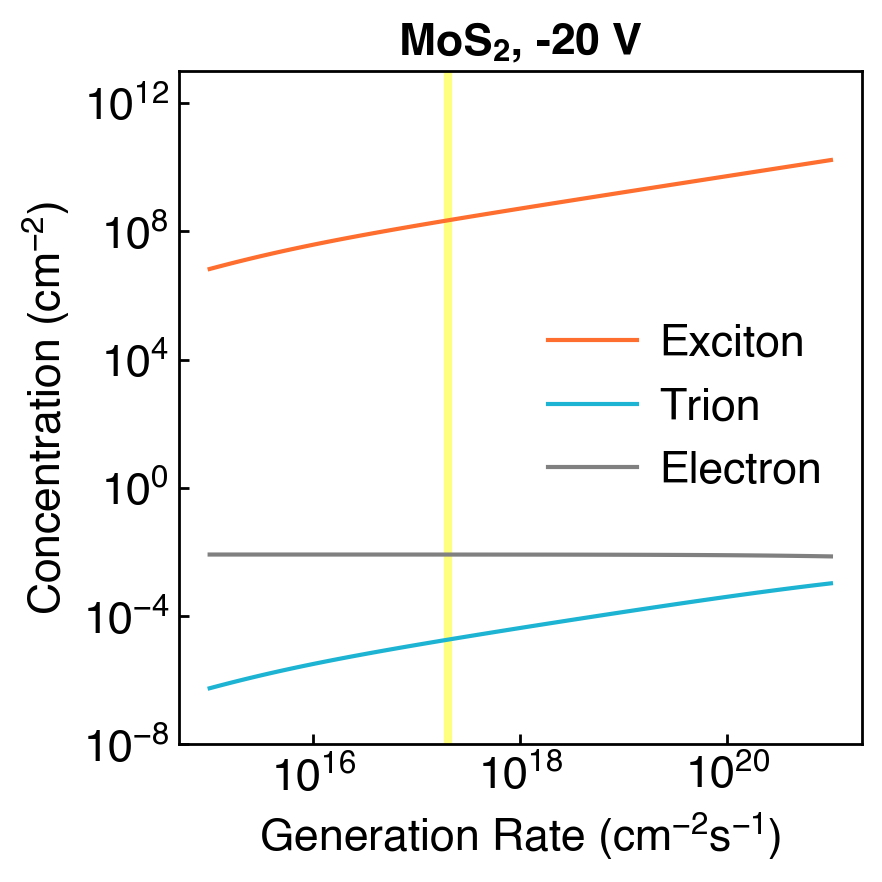

In [12]:
fig,ax=plt.subplots(figsize=size)
ax.axvline(x=2e17,color=[1,1,0,0.5],linewidth='3')
ax.loglog(gs,nxs,label='Exciton')
ax.loglog(gs,nts,label='Trion')
ax.loglog(gs,nes,label='Electron')
ax.set_ylim([1e-8,1e13])
ax.set_xlabel('Generation Rate ($cm^{-2}s^{-1}$)')
ax.set_ylabel('Concentration ($cm^{-2}$)')
ax.set_title('$'+tmds[tmd]+'$, '+str(V)+' V')
ax.legend()
#fig.savefig('figures/'+testing+key+'_conc')

Plot rates

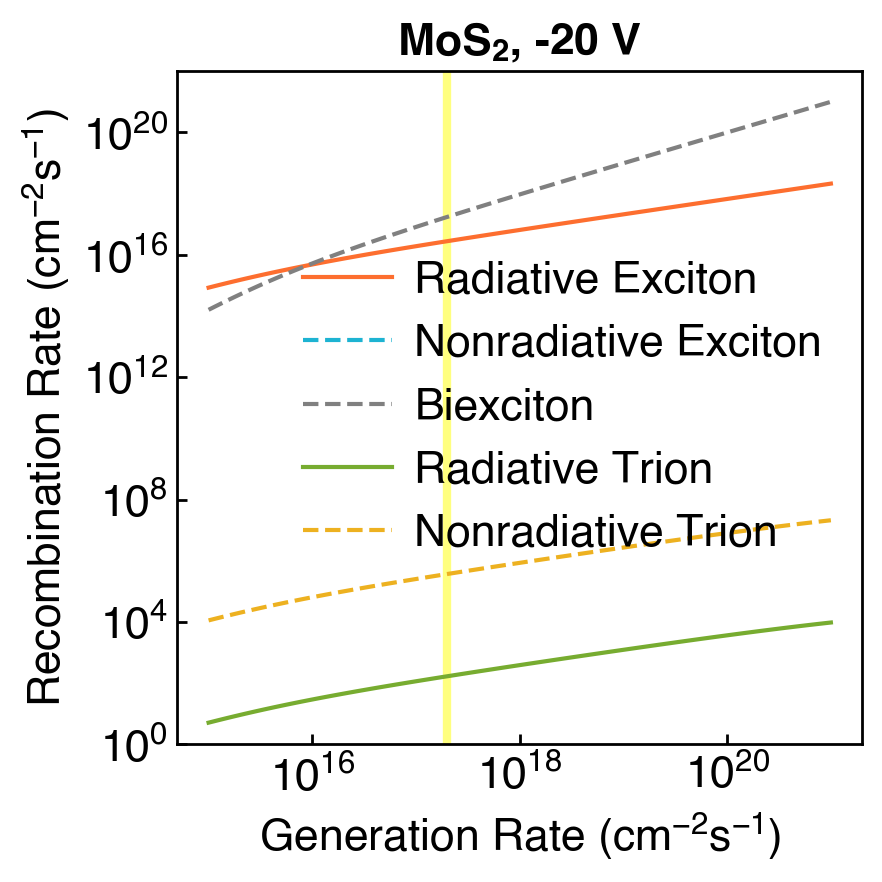

In [13]:
fig,ax=plt.subplots(figsize=size)
ax.axvline(x=2e17,color=[1,1,0,0.5],linewidth='3')
ax.loglog(gs,rxrs,label='Radiative Exciton')
ax.loglog(gs,rxnrs,'--',label='Nonradiative Exciton')
ax.loglog(gs,rbs,'--',label='Biexciton')
ax.loglog(gs,rtrs,label='Radiative Trion')
ax.loglog(gs,rtnrs,'--',label='Nonradiative Trion')
ax.set_ylim([1e0,1e22])
ax.set_xlabel('Generation Rate ($cm^{-2}s^{-1}$)')
ax.set_ylabel('Recombination Rate ($cm^{-2}s^{-1}$)')
ax.set_title('$'+tmds[tmd]+'$, '+str(V)+' V')
ax.legend(loc='best')
#fig.savefig('figures/'+testing+key+'_rates') #/changing-vth

Plot PLQY

KeyError: 'MoS_2_0V_sim'

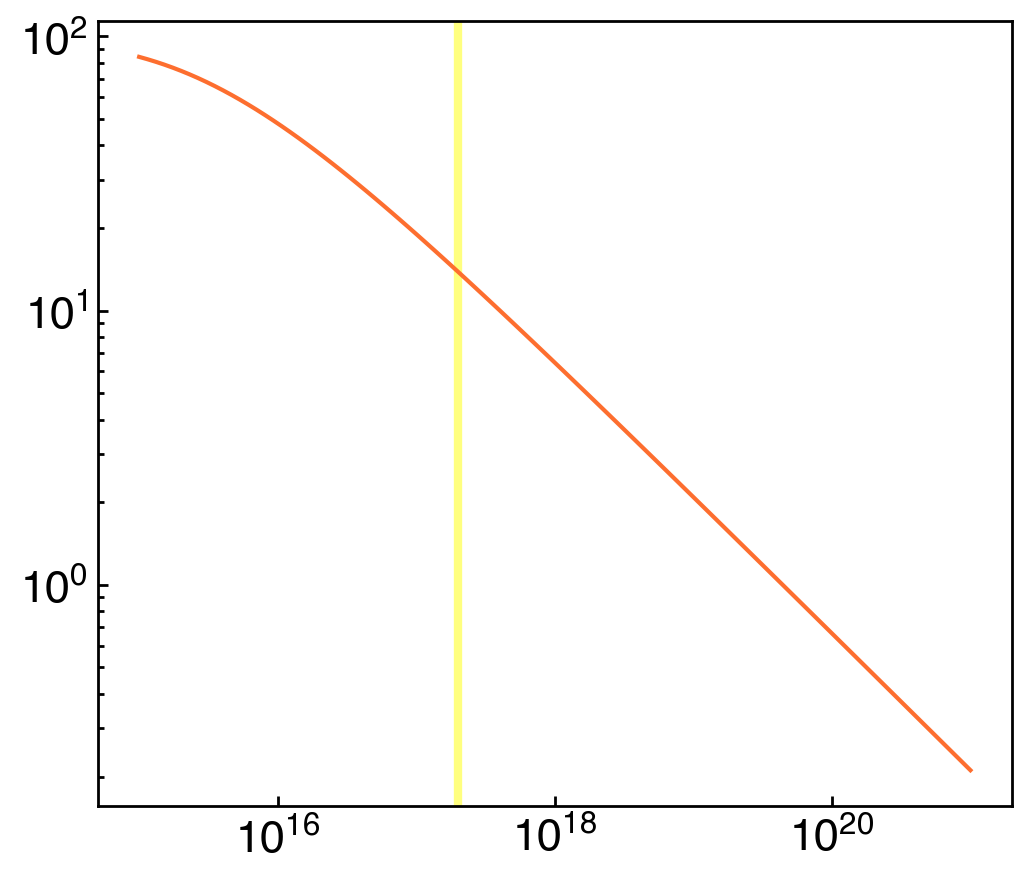

In [14]:
fig,ax=plt.subplots()
ax.axvline(x=2e17,color=[1,1,0,0.5],linewidth='3')
ax.loglog(gs,all_plqy[tmds[tmd]+'_-20V_sim']*100,label='-20 V')
ax.loglog(gs,all_plqy[tmds[tmd]+'_0V_sim']*100,label='0 V')
#ax.loglog(gs,all_plqy[tmds[tmd]+'_-5V_sim']*100,label='-5 V')
ax.loglog(gs,all_plqy[tmds[tmd]+'_20V_sim']*100,label='20 V')
ax.legend()
ax.loglog(all_plqy[tmds[tmd]+'_-20V_data'][:,0],all_plqy[tmds[tmd]+'_-20V_data'][:,1],'.',color='#FD6E2F')
ax.loglog(all_plqy[tmds[tmd]+'_0V_data'][:,0],all_plqy[tmds[tmd]+'_0V_data'][:,1],'.',color='#1DB3D2')
#ax.loglog(all_plqy[tmds[tmd]+'_-5V_data'][:,0],all_plqy[tmds[tmd]+'_-5V_data'][:,1],'.',color='#1DB3D2')
ax.loglog(all_plqy[tmds[tmd]+'_20V_data'][:,0],all_plqy[tmds[tmd]+'_20V_data'][:,1],'.',color='#808080')
ax.set_ylim([1e-2,1e2])
ax.set_xlabel('Generation Rate ($cm^{-2}s^{-1}$)')
ax.set_ylabel('PLQY (%)')
ax.set_title('$'+tmds[tmd]+'$')
#fig.savefig('figures/'+testing+tmds[tmd]+'_plqy')

Note that assuming a 1 nm thick TMD and an ideal bandgap, a generation rate of 2e17 cm^-2 s^-2 corresponds is what we need to achieve SQ:

2e17 cm^-2 s^-2 * 1.6e-19 C/photon = 3.2e-2 A/cm^2 = ~32 mA/cm^2 

This is an upper limit of generation because we likely won't have perfect absorption, and all monolayer TMDs have bandgaps larger than 1.35 eV.

### At desired G...

In [13]:
g_1sun=gs[abs(gs-2e17)==np.min(abs(gs-2e17))]

ne_1sun=nes[abs(gs-2e17)==np.min(abs(gs-2e17))][0]
nx_1sun=nxs[abs(gs-2e17)==np.min(abs(gs-2e17))][0]
nt_1sun=nts[abs(gs-2e17)==np.min(abs(gs-2e17))][0]

rxr_1sun=rxrs[abs(gs-2e17)==np.min(abs(gs-2e17))][0]
rb_1sun=rbs[abs(gs-2e17)==np.min(abs(gs-2e17))][0]
rtr_1sun=rtrs[abs(gs-2e17)==np.min(abs(gs-2e17))][0]
rtnr_1sun=rtnrs[abs(gs-2e17)==np.min(abs(gs-2e17))][0]


message=(f'At desired G: ne={ne_1sun:.3e} 1/cm^3 '
    f'nx={nx_1sun:.3e} 1/cm^2 '
    f'nt={nt_1sun:.3e} 1/cm^2 '
    f'nt={nt_1sun:.3e} 1/cm^2 ' 
         
    f'rxr={rxr_1sun:.3e} 1/cm^2s '
    f'rb={rb_1sun:.3e} 1/cm^2s ' 
    f'rtr={rtr_1sun:.3e} 1/cm^2s '
    f'rtnr={rtnr_1sun:.3e} 1/cm^2s '
        )

message

'At desired G: ne=3.499e+12 1/cm^3 nx=7.175e+05 1/cm^2 nt=2.008e+05 1/cm^2 nt=2.008e+05 1/cm^2 rxr=8.969e+13 1/cm^2s rb=1.802e+12 1/cm^2s rtr=1.826e+12 1/cm^2s rtnr=2.008e+17 1/cm^2s '

For MoSe2, nonradiative trion recombination is dominant with other components making up ~15% of recombination. Based on sensitivity of this modeling to e.g. initial carrier concentrations, it'll likely be best to incorporate biexcitons somehow!

In [14]:
#all_plqy
#dict = {'Python' : '.py', 'C++' : '.cpp', 'Java' : '.java'}
#f = open("all_plqy.txt","w")
#f.write( str(all_plqy) )
#f.close()

Things I double checked:

That the N, P calculation is spitting out something reasonable (corrected, but it wasn't sensitive to this)

The parameters for all 4 TMDs (WS2 had one incorrect one that helped: I had 0.32 instead of 0.032

The units on all parameters

The lifetimes

The equations within the generation for loop (triple checked!)

In [16]:
P

0.00415563405384523